In [1]:
from importlib import reload
import flymovie as fm
from flymovie.simnuc import Sim
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from importlib import reload
import umap
import scipy.ndimage as ndi
import skimage as ski
import matplotlib.image as mpimg
import tempfile
import shutil
import mixmod
import scipy.stats as stats

%load_ext autoreload
%autoreload 2

### Noise fit histogram

In [2]:
im = fm.read_czi('/Volumes/stadler_5tb/old-red/2022-03-21/26983-1-1-em2-17.czi', swapaxes=False)

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/stadler_5tb/old-red/2022-03-21/26983-1-1-em2-17.czi'

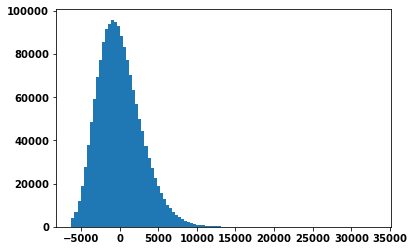

interactive(children=(Dropdown(description='Color', index=1, options=('prism', 'cividis', 'Gators', 'Reds', 'i…

In [139]:
t = 4500
sm = ndi.gaussian_filter(im, 3)
mask = np.where(sm > t, True, False)
nucmean = np.mean(im[mask])
diff = im - nucmean
resid_vals = diff[mask]
vals = im[mask]
plt.hist(resid_vals, bins=100);
fm.viewer(mask)

In [140]:
max_ = 15_000
mixture_onegauss = mixmod.MixtureModel([stats.norm], params=[{'loc': 5000, 'scale': 3000}])
mixture_gamma_gauss = mixmod.MixtureModel([stats.gamma, stats.norm], params=[{'a':1, 'scale':10_000},{'scale':10_000}])
vals = vals
mixture_onegauss.fit(data=vals)
mixture_gamma_gauss.fit(data=vals)


(157, -15576536.678086651)

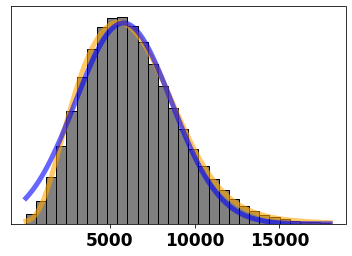

In [153]:
bins=100
max_ = 18_000
plt.hist(vals, bins=30, density=True, facecolor='grey', edgecolor='black', range=(vals.min(), max_));
x = np.linspace(vals.min(), max_, bins)
y = mixture_onegauss.pdf(x)
#plt.plot(x,y, linewidth=5, alpha=0.5, color="blue")
x = np.linspace(vals.min(), max_, bins)
y = mixture_gamma_gauss.pdf(x)
plt.plot(x,y, linewidth=5, alpha=0.6, color="orange")
y = stats.norm.pdf(x, loc=5800, scale=2836)
plt.plot(x,y, linewidth=5, alpha=0.6, color="blue")
plt.yticks([])
plt.xticks([5000, 10000, 15000], size=17)
#plt.xlabel('Pixel Intensity', size=17)
plt.savefig('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/figuredata/W2-describe-sim-msm/noise_hist.png', dpi=300)

### Panels of nuclei

In [2]:

def match_names_and_distcutoff(real_embedding_pkl, sims_embedding_pkl, cutoff_lower, cutoff_upper, savestem=None, pattern=''):
    """Extract the names of simulations that embed within a cutoff
    distance of the center of a reference set."""

    def embeddings_match_names(em, names, pattern):
        """Match names to a pattern, select corresponding rows of embedding."""
        if len(names) != em.shape[0]:
            raise ValueError('Sizes of embedding and names object do not match.')

        match_rows = pd.Series(names).str.contains(pattern).to_numpy()
        return em[match_rows], np.array(names)[match_rows]

    def dist_to_center(ref_arr, arr):
        """Get the euclidean distance between each row of arr to center (mean) of ref_arr."""
        center = ref_arr.mean(axis=0)
        sqdist = np.sum((arr - center) ** 2, axis=1)
        return np.sqrt(sqdist)

    em_real, names_real = fm.load_pickle(real_embedding_pkl)
    em_sims, names_sims = fm.load_pickle(sims_embedding_pkl)

    # Extract embedding rows and names of real nuclei that match pattern.
    em_ref, names_ref = embeddings_match_names(em_real, names_real, pattern)

    # Get names of sim files that are within distance cutoffs of selected real
    # nucs in embedding space.
    dists = dist_to_center(em_ref, em_sims)
    names = np.array(names_sims)[(dists <= cutoff_upper) & (dists > cutoff_lower)]

    # Optional: save the filenames as text files for separate extraction.
    if savestem is not None:
        np.savetxt(savestem + '_real.txt', names_ref, fmt='%s')
        np.savetxt(savestem + '_sims.txt', names, fmt='%s')
        
    return names_ref, names

def vis2(reals, sims, nsample):
    def load_folder(folder):
        l = []
        fnames = []
        for f in os.listdir(folder):
            if (f[0] == '.') or (f[-3:] != 'pkl'):
                continue
            im = fm.load_pickle(os.path.join(folder, f))
            l.append(im)
            fnames.append(f)
        return np.array(l), fnames
    
    def plot(ims, fig, vstart, nrows):
        print(ims.shape)
        for im in ims:
            min_, max_ = np.min(im), np.max(im) * 0.9
            ax = fig.add_axes((0,vstart,0.15,0.15))
            ax.imshow(im.max(axis=0), vmin=min_, vmax=max_, cmap='cividis')
            ax.axis('off')
            ax = fig.add_axes((0.18,vstart,0.15,0.15))
            ax.imshow(im[8], vmin=min_, vmax=max_*0.7, cmap='cividis')
            ax.axis('off')
            ax = fig.add_axes((0.34,vstart,0.15,0.15))
            ax.imshow(im[14], vmin=min_, vmax=max_*0.7, cmap='cividis')
            ax.axis('off')
            ax = fig.add_axes((0.50,vstart,0.15,0.15))
            ax.imshow(im[20], vmin=min_, vmax=max_*0.7, cmap='cividis')
            ax.axis('off')
            ax = fig.add_axes((0.66,vstart,0.15,0.15))
            ax.imshow(im[26], vmin=min_, vmax=max_*0.7, cmap='cividis')
            ax.axis('off')

            vstart = vstart - (1 / nrows * 0.77)


    ims_real, _ = load_folder(reals)
    real_idx_sampled = np.random.choice(np.arange(0, ims_real.shape[0]), size=np.min([nsample, ims_real.shape[0]]), replace=False)
    ims_real_sampled = ims_real[real_idx_sampled]

    ims_sims, simnames = load_folder(sims)
    sims_idx_sampled = np.random.choice(np.arange(0, ims_sims.shape[0]), size=np.min([nsample, ims_sims.shape[0]]), replace=False)
    ims_sims_sampled = ims_sims[sims_idx_sampled]

    nrows = nsample * 2
    fig = plt.figure(constrained_layout=False, facecolor='1', figsize=(8.48,12 * nrows / 6))
    plot(ims_real_sampled, fig, 0.89, nrows)
    plot(ims_sims_sampled, fig, 0.89 - (1 / nrows * (nsample + 0.25)), nrows)
    fig.savefig('/Users/michaelstadler/Desktop/test.png',dpi=300)





def plot_real_sim_pattern_cutoff(real_embedding_pkl, sims_embedding_pkl, dir_reals, dir_sims, pattern, cutoff_lower, cutoff_upper, savefile, nsample):
    def cp_files(fnames, nsample, srcdir, destdir):
        fnames_sampled = np.random.choice(fnames, size=np.min([nsample, len(fnames)]), replace=False)
        for f in fnames_sampled:
            fpath = os.path.join(srcdir, f)
            if os.path.exists(fpath):
                shutil.copy(fpath, destdir)
            

    em_real, names_real = fm.load_pickle(real_embedding_pkl)
    em_sim, names_sim = fm.load_pickle(sims_embedding_pkl)
    names_real, names_sim = extract_names_and_distcutoff(em_real, names_real, em_sim, names_sim, cutoff_lower, cutoff_upper, pattern=pattern)

    with tempfile.TemporaryDirectory() as tmpdir_reals:
        with tempfile.TemporaryDirectory() as tmpdir_sims:
            cp_files(names_real, nsample, dir_reals, tmpdir_reals)
            cp_files(names_sim, nsample, dir_sims, tmpdir_sims)
            vis2(tmpdir_reals, tmpdir_sims, nsample)
            

    # Make temp folder and stock
func1(real_embedding_pkl, rpb1_sims_embedding_pkl, dir_reals, dir_sims, pattern, 0, 0.5, savefile, 15)

NameError: name 'real_embedding_pkl' is not defined

In [ ]:
real_embedding_pkl = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__real-nuclei-set3-matched-20220630__20220619-plussims-20220616-realreal.pkl'
zld_sims_embedding_pkl = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__20220630-zld-nc13-70nm-library_GjGqzRyG__20220619-plussims-20220616-realreal.pkl'

dir_reals = '/Volumes/stadler_5tb/real-nuclei-set3-matched-20220630'
dir_sims = '/Volumes/stadler_5tb/matched_sim_images/rpb1-broad'

savefile = '/Users/michaelstadler/Desktop/test.png'
pattern = 'rpb1.*nc13-4_'
em_real, names_real = fm.load_pickle(real_embedding_pkl)
em_sim, names_sim = fm.load_pickle(rpb1_sims_embedding_pkl)

(3, 34, 100, 100)
(3, 34, 100, 100)


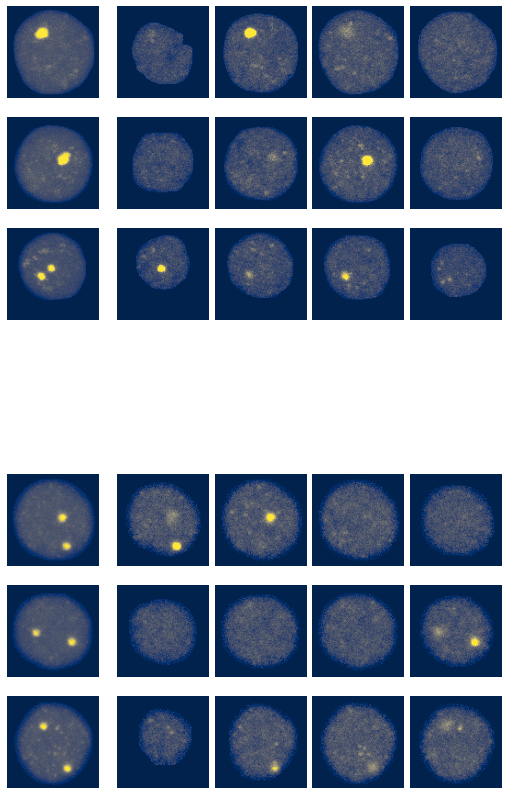

In [155]:
folder1 = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/matched_images/test_reals'
folder2 = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/matched_images/test_sims_0_03'

vis2(folder1, folder2, 3)

In [ ]:
def plot_real_sim_pattern_cutoff(real_embedding_pkl, sims_embedding_pkl, dir_reals, dir_sims, pattern, cutoff_lower, cutoff_upper, savefile, nsample):
    def cp_files(fnames, nsample, srcdir, destdir):
        fnames_sampled = np.random.choice(fnames, size=np.min([nsample, len(fnames)]), replace=False)
        for f in fnames_sampled:
            fpath = os.path.join(srcdir, f)
            if os.path.exists(fpath):
                shutil.copy(fpath, destdir)
            

    em_real, names_real = fm.load_pickle(real_embedding_pkl)
    em_sim, names_sim = fm.load_pickle(sims_embedding_pkl)
    names_real, names_sim = extract_names_and_distcutoff(em_real, names_real, em_sim, names_sim, cutoff_lower, cutoff_upper, pattern=pattern)

    with tempfile.TemporaryDirectory() as tmpdir_reals:
        with tempfile.TemporaryDirectory() as tmpdir_sims:
            cp_files(names_real, nsample, dir_reals, tmpdir_reals)
            cp_files(names_sim, nsample, dir_sims, tmpdir_sims)
            vis2(tmpdir_reals, tmpdir_sims, nsample)